# Final project
## Ilia Notin
### Choosing the best location in Milan (Itlay) for living

In [81]:
import sys 
import time
from geopy.geocoders import Nominatim, GoogleV3, Bing
import folium
from bs4 import BeautifulSoup
import requests
import numpy as np
import googleCreds
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn import preprocessing

### 1. Companies' locations


Specifying job name and region for the search and number of pages to work with.

In [2]:
jobName = "data+scientist"
locaionName = "Milano%2C+Lombardia"
maxPages = 5

I use indeed.com for job search as it allows easy web scraping with no restrictons and API's

In [3]:
urlList = [f"https://it.indeed.com/offerte-lavoro?q={jobName}&l={locaionName}"]  
urlList+=[f"https://it.indeed.com/jobs?q={jobName}&l={locaionName}&start={i}0" for i in range(1,maxPages+1)]
urlList

['https://it.indeed.com/offerte-lavoro?q=data+scientist&l=Milano%2C+Lombardia',
 'https://it.indeed.com/jobs?q=data+scientist&l=Milano%2C+Lombardia&start=10',
 'https://it.indeed.com/jobs?q=data+scientist&l=Milano%2C+Lombardia&start=20',
 'https://it.indeed.com/jobs?q=data+scientist&l=Milano%2C+Lombardia&start=30',
 'https://it.indeed.com/jobs?q=data+scientist&l=Milano%2C+Lombardia&start=40',
 'https://it.indeed.com/jobs?q=data+scientist&l=Milano%2C+Lombardia&start=50']

Now I collect company names from the search results into the list ...

In [4]:
companyNames = []

for url in urlList:
    session = requests.session()
    response = session.get(url)

    soup = BeautifulSoup(response.text, 'html.parser')

    for element in soup.find_all('span', class_='company'):
        #print(element)
        try:
            name = element.find('a', class_="turnstileLink").text.strip()
            #print(name)
        except:
            name = element.text.strip()
            #print(name)
        companyNames.append(name)
print(len(companyNames))

85


... and keep only unique ones using set

In [5]:
companyNames = list(set(companyNames))

In [6]:
print("Number of companies in the list:", len(companyNames))

Number of companies in the list: 59


In order to get companies' locations I need their address which I can get using Google Maps API. I had to create an account for that purpose. Credentials are stored in googleCreds.py for security reasons.

In [7]:
geolocator = GoogleV3(api_key = googleCreds.GOOGLE_API_KEY)

After I get the address based on search results I use it to get location (latitude and longitude) for each company.

In [8]:
#testing geolocator
location = geolocator.geocode("Via Pitagora, 27, Monza MB")
location[1] 

(45.5752584, 9.2531686)

Now I create a list of location objects using geolocator and trying to restrict location only by Milan area because some companies' HQs are located somewhere else in the world.

In [14]:
#location = geolocator.geocode("Milano Italy")
dct = {"name":[], 
       "lt" : [], 
       "lg" : [],
       "address" : []}

for company in companyNames:
    rawName = str(company+" Milano").replace(" ","+")
    url = 'https://maps.googleapis.com/maps/api/geocode/json?'+'address={}&key={}'.format(rawName,googleCreds.GOOGLE_API_KEY)
    p = {'address' : 'Milano'}
    r = requests.get(url, params = p).json()

    time.sleep(0.5)
    try:
        results = r['results']
        results = results[0]
    
        location = geolocator.geocode(results["formatted_address"])
        print(company + " was succesfully added with address:\n" + location.address + "\n")

        dct["name"].append(company)
        dct["lt"].append(location.latitude)
        dct["lg"].append(location.longitude)
        dct["address"].append(location.address)
    except:
        print(company + " was skipped. Probably was not found\n")



List Group was skipped. Probably was not found

Atos was succesfully added with address:
Via Caldera, 21, 20153 Milano MI, Italy

NXP Semiconductors was skipped. Probably was not found

Wixab was skipped. Probably was not found

Jakala was succesfully added with address:
Corso di Porta Romana, 15, 20122 Milano MI, Italy

Willis Towers Watson was succesfully added with address:
Via Vittor Pisani, 19, 20124 Milano MI, Italy

IQVIA was succesfully added with address:
Via Fabio Filzi, 29, 20124 Milano MI, Italy

Hunters Group was succesfully added with address:
Milan, Metropolitan City of Milan, Italy

IFOM was succesfully added with address:
Via Adamello, 16, 20139 Milano MI, Italy

PwC was succesfully added with address:
Via Pietro Custodi, 12, 20136 Milano MI, Italy

DiaSorin was skipped. Probably was not found

Ali Spa was succesfully added with address:
Via Larga, 2, 20122 Milano MI, Italy

Gresham Hunt was succesfully added with address:
107 Cheapside, London EC2V 6DN, UK

A2A S.p.A.

Not all of the companies were found succesfully, but it's fine. Now I create a dictionary for a subsequent dataframe containing info on companies location. In the same cycle I add markers into a feature group for the future folium map.

In [15]:
dfCompanies = pd.DataFrame(dct)
dfCompanies.sample(10)

,name,lt,lg,address
26,Veromont,-37.832312,145.187131,"9/170-180 Rooks Rd, Vermont VIC 3133, Australia"
1,Jakala,45.459194,9.190924,"Corso di Porta Romana, 15, 20122 Milano MI, Italy"
7,Ali Spa,45.462876,9.194306,"Via Larga, 2, 20122 Milano MI, Italy"
51,Sanmarco Informatica,45.600442,9.361084,"Torre Quercia, Via Torri Bianche, 9, 20871 Vim..."
36,GERI HDP SRL,45.435589,9.151115,"Via Lago di Nemi, 25, 20142 Milano MI, Italy"
40,AURIGA SPA,45.484071,9.200962,"Via Giovanni Battista Pirelli, 7, 20124 Milano..."
45,IBM,45.483658,9.189703,"Piazza Gae Aulenti, 20124 Milano MI, Italy"
19,Valuement,45.484136,9.197181,"Via Giovanni Battista Pirelli, 30, 20124 Milan..."
11,Spring Professional,45.461906,9.190078,"Piazza Armando Diaz, 7, 20123 Milano MI, Italy"
10,ABB,45.523464,9.232443,"Via Luciano Lama, 33, 20099 Sesto San Giovanni..."


In [16]:
dfCompanies.to_csv("1_dfCompanies.csv", index = False)

### 2. Mean and median locations

Here I calculate the mean and median location of the companies' location points which should be optimal for living.

In [17]:
meanLat = dfCompanies["lt"].mean()
meanLon = dfCompanies["lg"].mean()

medianLat = dfCompanies["lt"].median()
medianLon = dfCompanies["lg"].median()

medianLocation = (medianLat, medianLon)
meanLocation = (meanLat, meanLon)

In [18]:
print("Mean Location (lat, lon):", "\t" , meanLat, "\t" ,meanLon)
print("Median Location (lat, lon):", "\t" , medianLat, "\t\t" , medianLon)

Mean Location (lat, lon): 	 43.473300046153845 	 4.37133283076923
Median Location (lat, lon): 	 45.46976095 		 9.189982


### 4. Green Zones
The next step is to analyze how green each zone of Milan is. I used data on green zones in order to obtain Vegetation Concentration (area of green zones relative to total area).

In [19]:
#Source: https://dati.comune.milano.it/dataset/ds339-territorioambiente-aree-verdi-zona-superficie-2014
#Last Access Date: 11/08/2020
dfGreenRaw = pd.read_csv("ds339_territorioambiente_aree-verdi-zona-superficie_2014_2.csv",
                     header = 0, sep = ";")

In [20]:
dfGreenRaw.head()

,Zona,Area,ID Localitа,Nome localitа,Descrizione,Tipo,Classificazione,Classificazione ISTAT,AFFIDATARIO,Superficie totale in mq
0,1,1,1,piazza Castello - Minghetti,aiuola spartitraffico,Filare,Verde di arredo stradale,4 - Aree di arredo urbano,Appaltatore Servizio Manutenzione,"573,07"
1,1,2,2,piazza Paolo VI,area verde,Parco,Giardino,1 - Verde attrezzato,Appaltatore Servizio Manutenzione,"1313,85"
2,1,3,3,via San Simpliciano,filare alberato - parcheggio,Filare,Filare alberato,4 - Aree di arredo urbano,Appaltatore Servizio Manutenzione,"2,82"
3,1,4,4,via De Marchi Marco,filare alberato,Filare,Filare alberato,4 - Aree di arredo urbano,Appaltatore Servizio Manutenzione,"212,28"
4,1,5,5,via Croce Rossa,filare alberato,Filare,Filare alberato,4 - Aree di arredo urbano,Appaltatore Servizio Manutenzione,"6,47"


In [21]:
dfGreenRaw.dtypes

Zona                        int64
Area                        int64
ID Localitа                 int64
Nome localitа              object
Descrizione                object
Tipo                       object
Classificazione            object
Classificazione ISTAT      object
AFFIDATARIO                object
Superficie totale in mq    object
dtype: object

In [22]:
dfGreenRaw["Superficie totale in mq"] = dfGreenRaw["Superficie totale in mq"].apply(lambda x: float(str(x).replace(",",".")))

In [23]:
dfGreenRaw.dtypes

Zona                         int64
Area                         int64
ID Localitа                  int64
Nome localitа               object
Descrizione                 object
Tipo                        object
Classificazione             object
Classificazione ISTAT       object
AFFIDATARIO                 object
Superficie totale in mq    float64
dtype: object

Calculating green zone area for each zone

In [24]:
dfGreenRaw = dfGreenRaw.groupby(by="Zona").sum()
dfGreenRaw = dfGreenRaw.reset_index()
dfGreenRaw

,Zona,Area,ID Localitа,Superficie totale in mq
0,1,55548,116980,1108469.89
1,2,30772,177776,1067197.61
2,3,28190,196456,1732049.53
3,4,44075,350099,2133898.99
4,5,37416,366773,1745979.00
5,6,42285,458818,2125661.51
6,7,74550,671771,5294580.71
7,8,118343,1033605,3549902.76
8,9,116444,1193436,3677692.48


Getting info on total area of each zone from Wikipedia

In [25]:
dfZones = pd.read_html('https://en.wikipedia.org/wiki/Municipalities_of_Milan',
                          flavor='bs4')
dfZones = dfZones[1][:9]
dfZones

,Borough,Name,Area(km2),Population(2014),Population density(inhabitants/km2),Quartieri (districts)
0,1.0,Centro storico,9.67,96315.000,11074,"Brera, Centro Storico, Conca del Naviglio, Gua..."
1,2.0,"Stazione Centrale, Gorla, Turro, Greco, Cresce...",12.58,153.109,13031,"Adriano, Crescenzago, Gorla, Greco, Loreto, Ma..."
2,3.0,"Città Studi, Lambrate, Porta Venezia",14.23,141229.000,10785,"Casoretto, Cimiano, Città Studi, Dosso, Lambra..."
3,4.0,"Porta Vittoria, Forlanini",20.95,156.369,8069,"Acquabella, Calvairate, Castagnedo, Cavriano, ..."
4,5.0,"Vigentino, Chiaravalle, Gratosoglio",29.87,123779.000,4487,"Basmetto, Cantalupa, Case Nuove, Chiaravalle, ..."
5,6.0,"Barona, Lorenteggio",18.28,149000.000,8998,"Arzaga, Barona, Boffalora, Cascina Bianca, Con..."
6,7.0,"Baggio, De Angeli, San Siro",31.34,170814.000,6093,"Assiano, Baggio, Figino, Fopponino, Forze Arma..."
7,8.0,"Fiera, Gallaratese, Quarto Oggiaro",23.72,181669.000,8326,"Boldinasco, Bullona, Cagnola, Campo dei Fiori,..."
8,9.0,"Porta Garibaldi, Niguarda",21.12,181598.000,9204,"Affori, Bicocca, Bovisa, Bovisasca, Bruzzano, ..."


Merging two Data frames and calculating the new column

In [26]:
dfGreen = pd.concat([dfGreenRaw, dfZones],axis = 1)[["Zona","Superficie totale in mq","Area(km2)"]]
#Had to rename column because geojson file had ZONADEC variable for zone number. 
#I'll need that when creating a map.
dfGreen.columns = ["ZONADEC","GreenArea", "TotalArea"]


In [27]:
#Converting m2 to km2
dfGreen["GreenArea"] = dfGreen["GreenArea"]/1000000
dfGreen

,ZONADEC,GreenArea,TotalArea
0,1,1.108470,9.67
1,2,1.067198,12.58
2,3,1.732050,14.23
3,4,2.133899,20.95
4,5,1.745979,29.87
5,6,2.125662,18.28
6,7,5.294581,31.34
7,8,3.549903,23.72
8,9,3.677692,21.12


In [28]:
dfGreen["GreenConc"] = dfGreen["GreenArea"]/dfGreen["TotalArea"]
dfGreen

,ZONADEC,GreenArea,TotalArea,GreenConc
0,1,1.108470,9.67,0.114630
1,2,1.067198,12.58,0.084833
2,3,1.732050,14.23,0.121718
3,4,2.133899,20.95,0.101857
4,5,1.745979,29.87,0.058453
5,6,2.125662,18.28,0.116283
6,7,5.294581,31.34,0.168940
7,8,3.549903,23.72,0.149659
8,9,3.677692,21.12,0.174133


In [29]:
dfGreen.to_csv("4_dfGreen.csv", index = False)

### 5. Air Quality
In this section I analyze data on contamination for 2019 and 2020 obtained from stations located in Milano.
I will calculate an Eco score which is an inverted value of mean normalized concentrations of contaminants.

In [30]:
dfAirRaw = pd.read_csv('https://dati.comune.milano.it/dataset/ccf8b61d-728f-46e7-bee9-e685c7b6cd35/resource/88c1e729-420e-433f-9397-875b54aa471d/download/qaria_datoariagiornostazione_2020-11-07.csv',
                          sep=';')

dfAirRaw.dropna(inplace = True)
dfAirRaw.sample(10)

,stazione_id,data,inquinante,valore
4829,3,2020/02/24,NO2,89.0
689,4,2020/10/14,C6H6,1.9
82,7,2020/11/16,O3,37.0
4082,6,2020/04/01,CO_8h,0.5
4260,7,2020/03/23,PM10,26.0
3530,6,2020/04/30,C6H6,0.5
2869,2,2020/06/09,O3,68.0
2284,2,2020/07/08,O3,108.0
5412,7,2020/01/23,NO2,109.0
4445,7,2020/03/13,O3,60.0


Checking contaminants (inquinante) types ... 

In [31]:
dfAirRaw["inquinante"].unique()

array(['O3', 'NO2', 'PM10', 'C6H6', 'CO_8h', 'PM25', 'SO2'], dtype=object)

... and ids of active stations 

In [32]:
dfAirRaw["stazione_id"].unique()

array([7, 6, 4, 3, 2])

Here I scale data within each contaminant type

In [33]:
#df['norm_w'] = df['weight'] / df.groupby('word')['weight'].transform('sum')
dfAirRaw["normv"] = dfAirRaw['valore'] / dfAirRaw.groupby('inquinante')['valore'].transform('max')
dfAirRaw.sample(10)

,stazione_id,data,inquinante,valore,normv
1264,2,2020/09/14,C6H6,0.5,0.066667
4568,6,2020/03/06,PM25,19.0,0.125000
3359,2,2020/05/12,PM10,11.0,0.061111
5300,3,2020/01/29,NO2,90.0,0.420561
4180,6,2020/03/26,PM25,14.0,0.092105
4463,2,2020/03/12,SO2,9.0,0.230769
692,4,2020/10/14,PM10,24.0,0.133333
3938,6,2020/04/08,PM25,26.0,0.171053
5508,4,2020/01/20,C6H6,2.7,0.360000
1288,4,2020/09/11,NO2,114.0,0.532710


In [34]:
dfAirRaw["data"] = pd.to_datetime(dfAirRaw["data"])
dfAirRaw = dfAirRaw.sort_values(by="data")
dfAirRaw

,stazione_id,data,inquinante,valore,normv
5819,2,2020-01-01,SO2,5.0,0.128205
5792,2,2020-01-02,C6H6,4.3,0.573333
5793,2,2020-01-02,PM10,154.0,0.855556
5794,2,2020-01-02,PM25,129.0,0.848684
5795,3,2020-01-02,NO2,122.0,0.570093
...,...,...,...,...,...
22,2,2020-11-19,PM25,30.0,0.197368
23,2,2020-11-19,PM10,43.0,0.238889
24,2,2020-11-19,SO2,5.0,0.128205
15,4,2020-11-19,NO2,61.0,0.285047


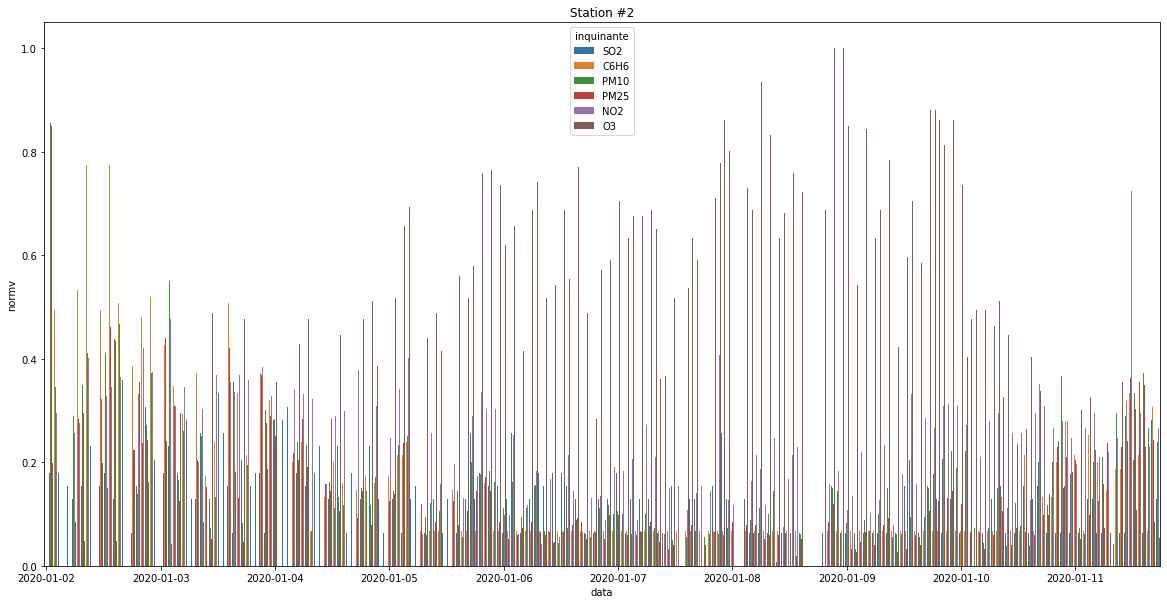

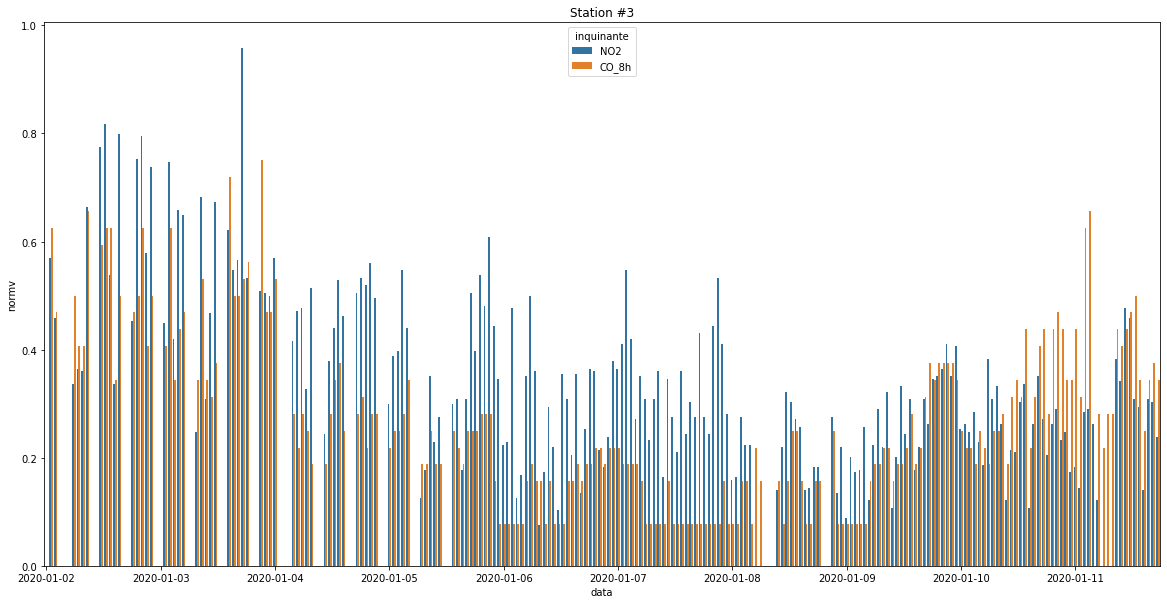

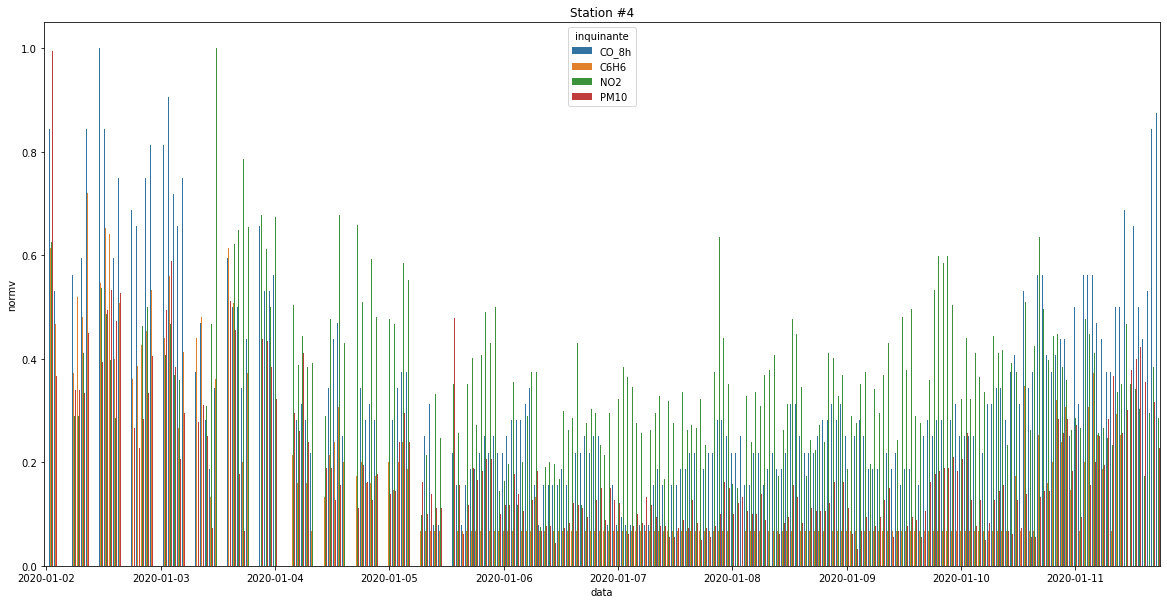

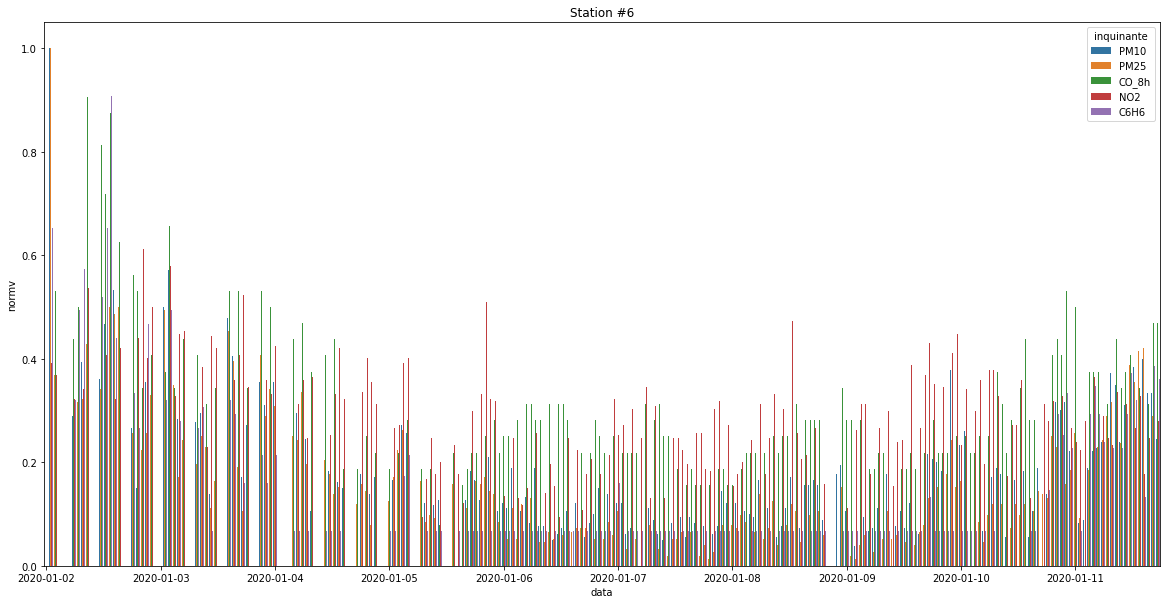

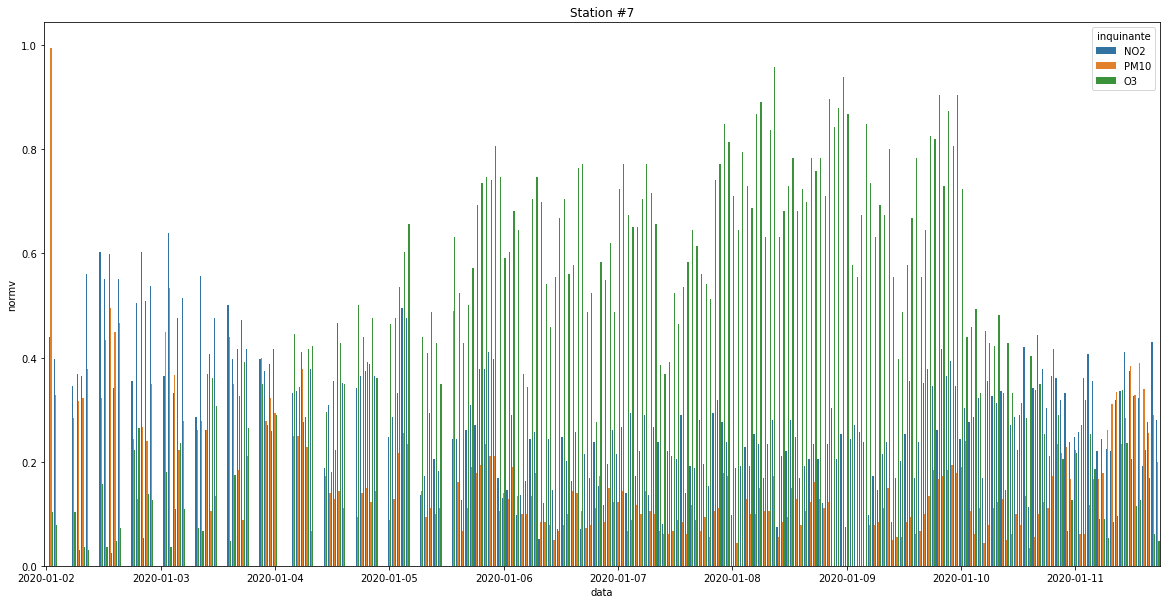

In [35]:


for station in dfAirRaw["stazione_id"].unique():
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.barplot(x = dfAirRaw["data"].dt.strftime('%Y-%m-%d'), y = "normv", 
                     data = dfAirRaw[dfAirRaw["stazione_id"] == station], 
                     hue = "inquinante")
    plt.title(f"Station #{station}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator())

In [36]:
#Let's check the data on air quality for 2019 
#Source: https://dati.comune.milano.it/dataset/3e752fec-06fd-421b-ae9b-4d5d7a177640/resource/698a58e6-f276-44e1-92b1-3d2b81a4ad47/download/qaria_datoariagiornostazione_2020-01-08.csv

dfAir2019 = pd.read_csv('https://dati.comune.milano.it/dataset/3e752fec-06fd-421b-ae9b-4d5d7a177640/resource/698a58e6-f276-44e1-92b1-3d2b81a4ad47/download/qaria_datoariagiornostazione_2020-01-08.csv',
                          sep=',')

dfAir2019.dropna(inplace = True)

dfAir2019["data"] = pd.to_datetime(dfAir2019["data"])
dfAir2019 = dfAir2019.sort_values(by="data")
dfAir2019


dfAir2019.sample(10)

,stazione_id,data,inquinante,valore
2421,4,2019-05-24,PM10,25.0
2491,7,2019-05-28,NO2,34.0
5528,6,2019-11-21,PM25,19.0
3592,4,2019-07-31,NO2,46.0
966,4,2019-03-04,NO2,144.0
292,4,2019-01-21,C6H6,2.9
2180,7,2019-05-10,O3,92.0
383,6,2019-01-25,C6H6,3.7
3396,6,2019-07-16,PM25,3.0
4672,6,2019-10-04,CO_8h,0.8


In [37]:
print(dfAir2019["stazione_id"].unique())
dfAir2019["normv"] = dfAir2019['valore'] / dfAir2019.groupby('inquinante')['valore'].transform('max')
dfAir2019["data"] = pd.to_datetime(dfAir2019["data"])
dfAir2019 = dfAir2019.sort_values(by="data")
dfAir2019

[3 7 6 2 4]


,stazione_id,data,inquinante,valore,normv
0,3,2019-01-03,NO2,51.0,0.217949
5,4,2019-01-03,C6H6,1.5,0.241935
9,2,2019-01-03,PM10,20.0,0.162602
8,2,2019-01-03,SO2,2.5,0.067568
1,3,2019-01-03,CO_8h,1.2,0.324324
...,...,...,...,...,...
6154,6,2019-12-31,CO_8h,1.2,0.324324
6155,6,2019-12-31,C6H6,1.5,0.241935
6147,2,2019-12-31,PM25,42.0,0.500000
6142,4,2019-12-31,C6H6,1.6,0.258065


In [38]:
dfAir2019[dfAir2019["stazione_id"] == 7]

,stazione_id,data,inquinante,valore,normv
21,7,2019-01-03,NO2,54.0,0.230769
20,7,2019-01-03,PM10,32.0,0.260163
22,7,2019-01-03,O3,59.0,0.263393
48,7,2019-01-04,O3,55.0,0.245536
47,7,2019-01-04,NO2,82.0,0.350427
...,...,...,...,...,...
6106,7,2019-12-24,O3,44.0,0.196429
6132,7,2019-12-30,O3,14.0,0.062500
6131,7,2019-12-30,NO2,84.0,0.358974
6157,7,2019-12-31,NO2,56.0,0.239316


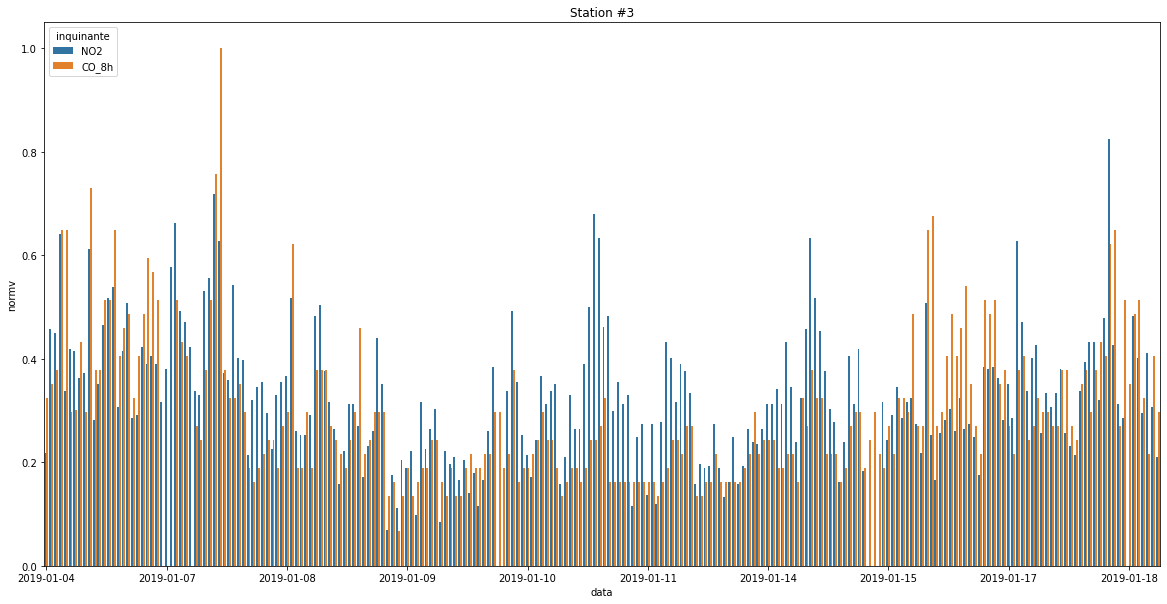

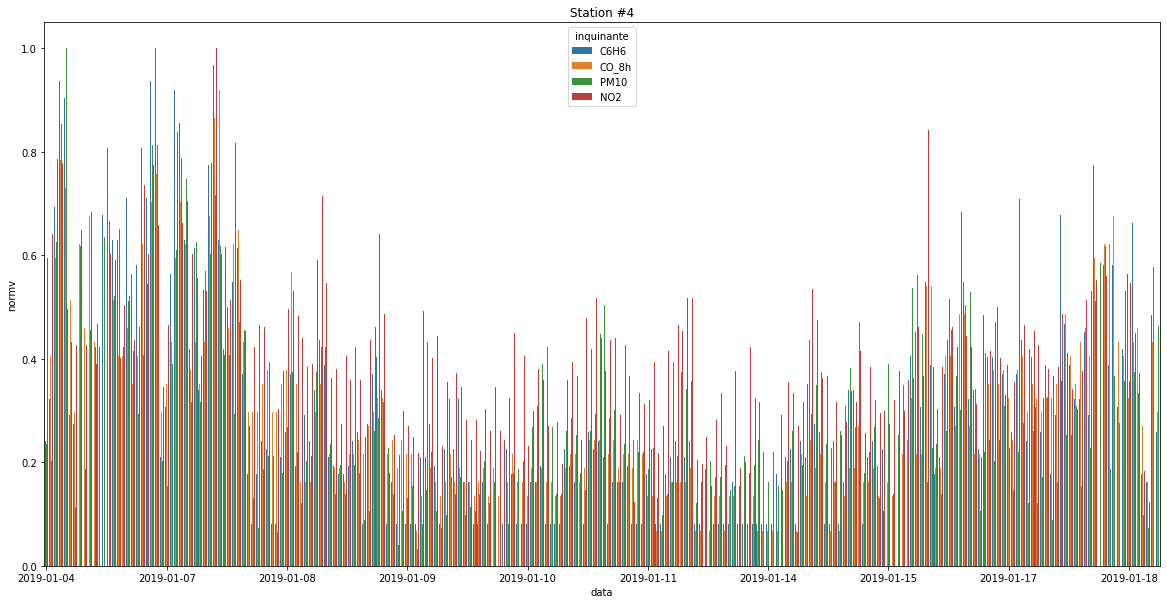

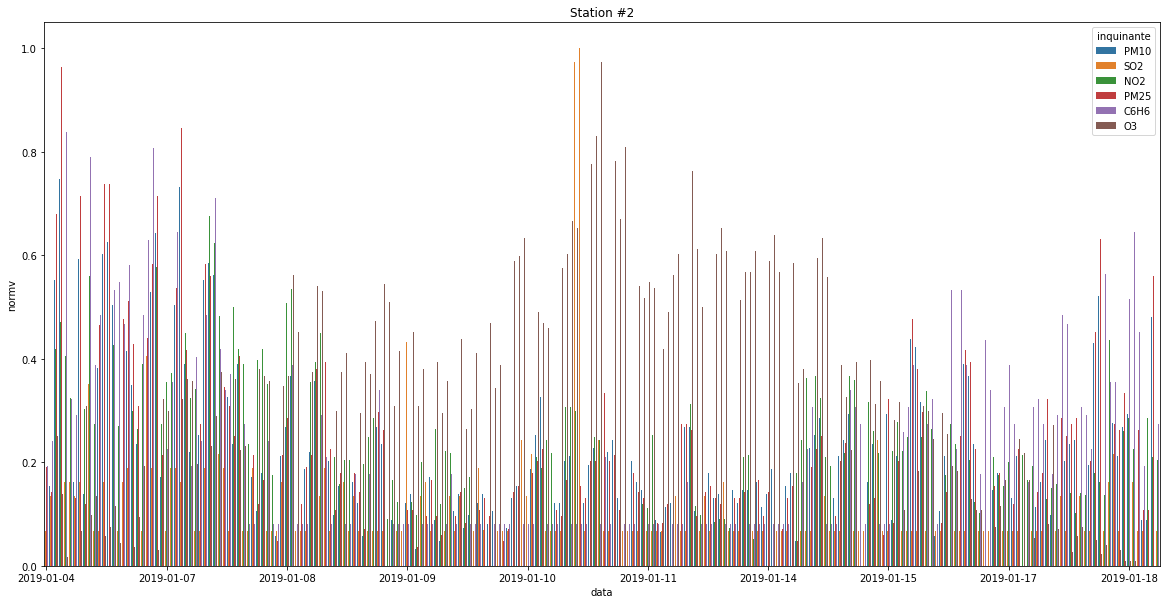

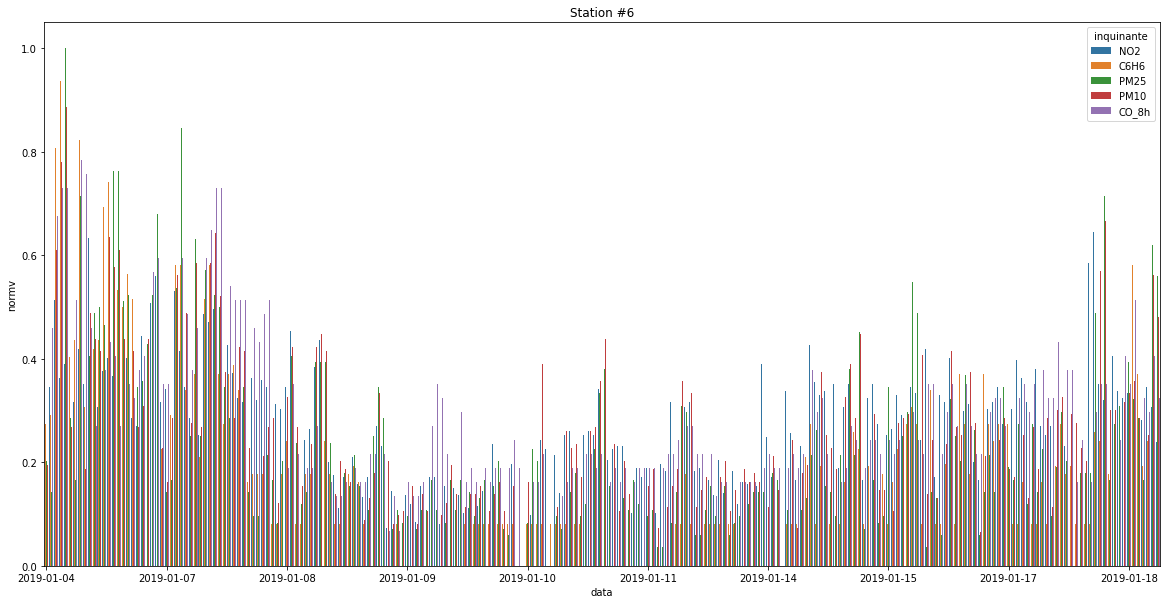

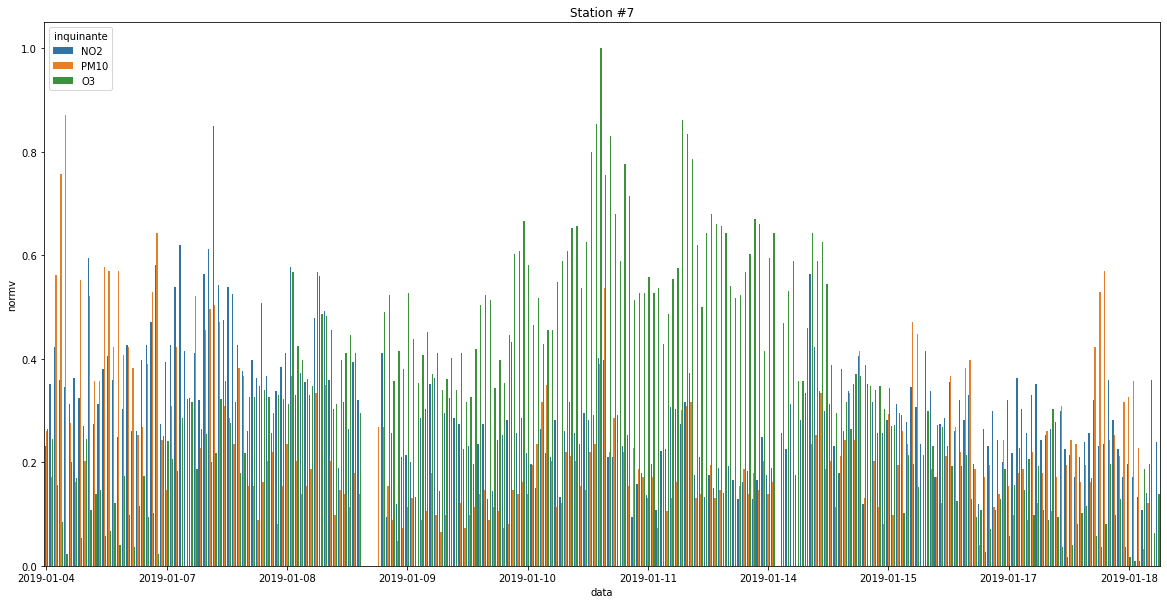

In [39]:
for station in dfAir2019["stazione_id"].unique():
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.barplot(x = dfAir2019["data"].dt.strftime('%Y-%m-%d'), y = "normv", 
                     data = dfAir2019[dfAir2019["stazione_id"] == station], 
                     hue = "inquinante")
    plt.title(f"Station #{station}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator())

We can see that the picture is almost the same for last year and this year. So there's a clear evidence of  seasonality. But analyzing this time series data is out of scope as it would not contribute much to the final goal. But let's check if median values are significantly different

Below I calculate the median value of scaled contamination by all available parameters (contaminants). Even though each station has different set of contaminant data, median value can provide a basis for comparative assesment of contamination.

In [40]:
dfAirScaledMedian = dfAirRaw.groupby(by="stazione_id").median()


In [41]:
dfAirScaledMedian = dfAirScaledMedian.reset_index()
dfAirScaledMedian.columns = ["id_amat", "valore", "normv"]

In [42]:
dfAirScaledMedian

,id_amat,valore,normv
0,2,12.0,0.150000
1,3,2.2,0.281250
2,4,8.5,0.218750
3,6,14.0,0.200000
4,7,52.0,0.261397


Let's check if median values are significantly different for stations 3 and 7 as they are pretty close. For that purpose I will use Kruskal-Wallis test (similar to ANOVA but for medians). 

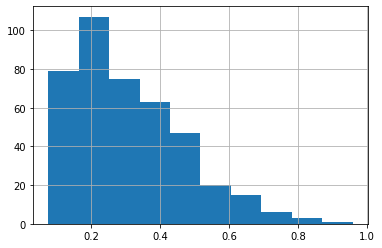

In [43]:
dfAirRaw[dfAirRaw["stazione_id"]==3]["normv"].hist()

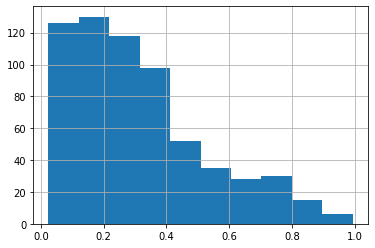

In [44]:
dfAirRaw[dfAirRaw["stazione_id"]==7]["normv"].hist()

In [45]:
from scipy import stats

stats.kruskal(dfAirRaw[dfAirRaw["stazione_id"]==7]["normv"].values, dfAirRaw[dfAirRaw["stazione_id"]==3]["normv"].values)

KruskalResult(statistic=1.4560617584771147, pvalue=0.2275577771110495)

p-value is more than 0.05, so these 2 stations do not have significantly different medians. Let's do the same pairwise test for all of the stations.

In [46]:
testRes = np.zeros((8,8))
for i in dfAirRaw["stazione_id"].unique():

    for j in dfAirRaw["stazione_id"].unique():
        if i!=j:
            A = dfAirRaw[dfAirRaw["stazione_id"]==i]["normv"].values
            B = dfAirRaw[dfAirRaw["stazione_id"]==j]["normv"].values
            res = stats.kruskal(A, B).pvalue
            print(f"for {i}|{j} pvalue = {res}. Significant difference = {res<=0.05}")
            testRes[i, j] = res
            

for 2|3 pvalue = 1.2271780358856927e-40. Significant difference = True
for 2|4 pvalue = 4.934603346343115e-20. Significant difference = True
for 2|6 pvalue = 4.3253964522248394e-08. Significant difference = True
for 2|7 pvalue = 3.8057167382042464e-34. Significant difference = True
for 3|2 pvalue = 1.2271780358856927e-40. Significant difference = True
for 3|4 pvalue = 5.740214822437114e-09. Significant difference = True
for 3|6 pvalue = 1.202234194960068e-22. Significant difference = True
for 3|7 pvalue = 0.2275577771110495. Significant difference = False
for 4|2 pvalue = 4.934603346343115e-20. Significant difference = True
for 4|3 pvalue = 5.740214822437114e-09. Significant difference = True
for 4|6 pvalue = 1.5018002096454752e-05. Significant difference = True
for 4|7 pvalue = 5.491339303647428e-06. Significant difference = True
for 6|2 pvalue = 4.3253964522248394e-08. Significant difference = True
for 6|3 pvalue = 1.202234194960068e-22. Significant difference = True
for 6|4 pvalue =

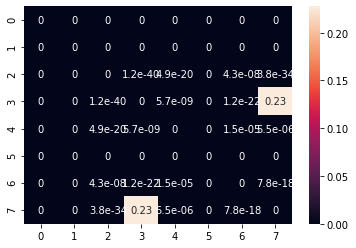

In [47]:
sns.heatmap(testRes, annot = True)

In [48]:
dfAirScaledMedian

,id_amat,valore,normv
0,2,12.0,0.150000
1,3,2.2,0.281250
2,4,8.5,0.218750
3,6,14.0,0.200000
4,7,52.0,0.261397


Retrieving data from geojson for stations.

In [49]:
import json
with open('qaria_stazione.geojson') as data_file:
    
    data = json.load(data_file)
dctStations = {"id_amat":[], 
               "name" : [], 
               "coords" : []}

for i in data["features"]:
    dctStations["id_amat"].append(i["properties"]["id_amat"])
    dctStations["name"].append(i["properties"]["nome"])
    dctStations["coords"].append([i["geometry"]["coordinates"][1], i["geometry"]["coordinates"][0]])
    
dfStations = pd.DataFrame(dctStations)
dfStations

,id_amat,name,coords
0,1,p.le Abbiategrasso,"[45.432300567627, 9.18218994140625]"
1,3,viale Liguria,"[45.4441986083984, 9.16944026947021]"
2,4,viale Marche,"[45.4962997436523, 9.19083976745605]"
3,5,Parco Lambro,"[45.4995994567871, 9.24730014801025]"
4,7,Verziere,"[45.4635009765625, 9.19534015655518]"
5,8,p.le Zavattari,"[45.4761009216309, 9.141770362854]"
6,9,via Juvara,"[45.4734992980957, 9.22045040130615]"
7,2,via Pascal *,"[45.4740982055664, 9.23478031158447]"
8,6,via Senato *,"[45.4705009460449, 9.19791984558105]"


In [50]:
dfStations.to_csv("dfStations.csv", header = False)

In [51]:
dfAirScaledMedianStations = dfAirScaledMedian.merge(dfStations, left_on='id_amat', right_on='id_amat')
dfAirScaledMedianStations

,id_amat,valore,normv,name,coords
0,2,12.0,0.150000,via Pascal *,"[45.4740982055664, 9.23478031158447]"
1,3,2.2,0.281250,viale Liguria,"[45.4441986083984, 9.16944026947021]"
2,4,8.5,0.218750,viale Marche,"[45.4962997436523, 9.19083976745605]"
3,6,14.0,0.200000,via Senato *,"[45.4705009460449, 9.19791984558105]"
4,7,52.0,0.261397,Verziere,"[45.4635009765625, 9.19534015655518]"


Need to separate the coordinates for further modelling

In [52]:
dfAirScaledMedianStations["lt"] = dfAirScaledMedianStations["coords"].map(lambda x: x[0])
dfAirScaledMedianStations["lg"] = dfAirScaledMedianStations["coords"].map(lambda x: x[1])
dfAirScaledMedianStations

,id_amat,valore,normv,name,coords,lt,lg
0,2,12.0,0.150000,via Pascal *,"[45.4740982055664, 9.23478031158447]",45.474098,9.23478
1,3,2.2,0.281250,viale Liguria,"[45.4441986083984, 9.16944026947021]",45.444199,9.16944
2,4,8.5,0.218750,viale Marche,"[45.4962997436523, 9.19083976745605]",45.496300,9.19084
3,6,14.0,0.200000,via Senato *,"[45.4705009460449, 9.19791984558105]",45.470501,9.19792
4,7,52.0,0.261397,Verziere,"[45.4635009765625, 9.19534015655518]",45.463501,9.19534


In [53]:
dfAirScaledMedianStations.to_csv("5_dfAirScaledMedianStations.csv", index = False)

### 6. Creating model for predicting air quality score based on location

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=3)
X = pf.fit_transform(dfAirScaledMedianStations[["lt","lg"]])

y = dfAirScaledMedianStations[["normv"]]
lr = LinearRegression()
lr.fit(X,y)

print(lr.coef_)
print(lr.intercept_)

[[-1.28816925e-03 -6.37745178e+00  1.39316957e+01 -2.91746662e+02
   2.87128002e+02  1.27924294e+02  4.65778863e+00 -5.28739683e+00
  -6.84877509e+00  4.88589661e+00]]
[157660.83791811]


In [55]:
def predictContamination(lt, lg):
    """
    The function returns contamination values based on location
    Input:
    lt (float): latitude
    lg (float): longitude
    
    Output:
    Scaled contamaination value
    """
    return lr.predict(pf.fit_transform([np.array([lt,lg])]))[0][0]

In [56]:
#checking
predictContamination(45.474098, 9.23478)

0.150004474184243

Saving the model for further map creation.

In [57]:
import pickle

pkl_filename = "lr.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lr, file)


### 7. Data on available apartments for rent

Getting data on existing offers for rent in Milan

In [58]:
minPrice = 500
maxPrice = 5000
maxPages = 50
urlList = [f"https://www.immobiliare.it/affitto-case/milano/?criterio=rilevanza&prezzoMinimo={minPrice}&prezzoMassimo={maxPrice}"]
urlList+=[f"https://www.immobiliare.it/affitto-case/milano/?criterio=rilevanza&prezzoMinimo={minPrice}&prezzoMassimo={maxPrice}&pag={i+1}" for i in range(maxPages)]

objects = {"id":[],
           "type":[], 
           "address":[],
           "price":[]}
for url in urlList:
    session = requests.session()
    response = session.get(url+"&boxAuto[]=1&boxAuto[]=4")

    soup = BeautifulSoup(response.text, 'html.parser')

    for element in soup.find_all('p', class_='titolo text-primary'):
        try:
            name = element.text.strip().split()
            objects["id"].append(element.find('a').get("id"))
            objects["type"].append(name[0])
            objects["address"].append(" ".join(name[1:]))
        except:
            pass

    for element in soup.find_all('li', class_='lif__item lif__pricing'):
        try:
            if element.find('div')==None:

                price = element.text.strip().split()[1]
                price= price.replace(".","")
                objects["price"].append(int(price))
            else:
                
                price = element.find('div').text.strip().split()[1]
                price= price.replace(".","")
            
                objects["price"].append(int(price))
        except:
            pass

        #Sanity check        
assert len(objects["id"]) == len(objects["type"]) == len(objects["address"]) == len(objects["price"])
print(f"All successful. {len(objects['id'])} objects has been added")

All successful. 1048 objects has been added


In [59]:
dfObjects = pd.DataFrame(objects)
dfObjects

,id,type,address,price
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000
2,link_ad_79920811,Bilocale,"corso Indipendenza 18, Indipendenza, Milano",1350
3,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200
4,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550
...,...,...,...,...
1043,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750
1044,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100
1045,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850
1046,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600


In [60]:
def getLoc(address, annot = True):
    """
    The function returns coordinates of address.
    Input:
    address (str): address
    
    Output:
    list(float): [latitude, longitude] or np.nan if not found
    """
    try:
        location = geolocator.geocode(address)
        if annot:
            print(address + " was succesfully added\n")
        return [location[1][0], location[1][1]]
        
    except:
        if annot:
            print(address + " was skipped. Probably was not found\n")
        return np.nan


In [61]:
dfObjects["coords"] = dfObjects["address"].map(getLoc)

piazzale Biancamano 2, Moscova, Milano was succesfully added

corso Magenta, San Vittore, Milano was succesfully added

corso Indipendenza 18, Indipendenza, Milano was succesfully added

via Archimede, Plebisciti - Susa, Milano was succesfully added

via Sansovino 3, Città Studi, Milano was succesfully added

via Carlo Imbonati 64, Dergano, Milano was succesfully added

via Fortezza 44, Villa San Giovanni, Milano was succesfully added

corso Giuseppe Garibaldi 95, Moscova, Milano was succesfully added

via Archimede, Indipendenza, Milano was succesfully added

unifamiliare via Bracciano 11, Zara, Milano was succesfully added

ottimo stato, 11, Duomo, Milano was succesfully added

ottimo stato, nono piano, Duomo, Milano was succesfully added

viale Legioni Romane 8, Bande Nere, Milano was succesfully added

corso Magenta, San Vittore, Milano was succesfully added

via Pinamonte da Vimercate, Moscova, Milano was succesfully added

via Moncalvo 46, Gambara, Milano was succesfully added

v

via Pietro Andrea Saccardo 7, Lambrate, Milano was succesfully added

via Ponale 6, Bignami - Ponale, Milano was succesfully added

nuovo, quarto piano, Porta Nuova, Milano was succesfully added

via Carlo Imbonati 62, Dergano, Milano was succesfully added

via Giovanni Battista Pirelli 30, Melchiorre Gioia, Milano was succesfully added

via Andrea Maria Ampère 56, Città Studi, Milano was succesfully added

via Carlo Dolci 32, San Siro, Milano was succesfully added

via Lattanzio, Lodi - Brenta, Milano was succesfully added

ottimo stato, secondo piano, Cadorna - Castello, Milano was succesfully added

ottimo stato, secondo piano, Cadorna - Castello, Milano was skipped. Probably was not found

via degli Arcimboldi 5, Missori, Milano was succesfully added

Vincenzo Monti 54, Vincenzo Monti, Milano was succesfully added

via Giambellino, Giambellino, Milano was succesfully added

viale Ergisto Bezzi 2, Gambara, Milano was succesfully added

via Mario Pagano 49, Pagano, Milano was succesf

via De Togni, San Vittore, Milano was succesfully added

via Privata della Passarella 4, Duomo, Milano was succesfully added

via Carlo Maria Maggi 2, Arena, Milano was succesfully added

via Volturno, Isola, Milano was succesfully added

via Giorgio Washington 59, Washington, Milano was succesfully added

via Cappuccini, Palestro, Milano was succesfully added

via dei Fontanili 32, Ripamonti, Milano was succesfully added

a schiera piazza Niccolò Tommaseo 2, Vincenzo Monti, Milano was succesfully added

via Giampietro Lucini 19, Maggiolina, Milano was succesfully added

ottimo stato, secondo piano, Plebisciti - Susa, Milano was succesfully added

via Vergani Marelli 1, Bande Nere, Milano was succesfully added

via Confalonieri, Isola, Milano was succesfully added

via Morigi, Carrobbio, Milano was succesfully added

viale Sarca 326, Bignami - Ponale, Milano was succesfully added

via Fabrizio De Andrè 8, Chiesa Rossa, Milano was succesfully added

via Pagliano, Monte Rosa - Lotto, Mil

via Gaetano Donizetti, Palestro, Milano was succesfully added

via Giovanni Spadolini, Ripamonti, Milano was skipped. Probably was not found

via Val Morea 6, Baggio, Milano was succesfully added

via via monviso 32, Paolo Sarpi, Milano was succesfully added

largo Quinto Alpini 1, Vincenzo Monti, Milano was succesfully added

via Giuseppe Ugolini 27, Greco - Segnano, Milano was succesfully added

largo Cairoli, Cadorna - Castello, Milano was succesfully added

piazza Mondadori 1, Quadronno - Crocetta, Milano was succesfully added

viale JENNER, Bovisa, Milano was succesfully added

via Giorgio Washington, Washington, Milano was succesfully added

via Giuseppe Ripamonti 1, Porta Romana - Medaglie d'Oro, Milano was succesfully added

viale Bligny 25, Bocconi, Milano was succesfully added

via Michelangelo Buonarroti, Vercelli - Wagner, Milano was succesfully added

alzaia Naviglio Pavese 260, Cantalupa - San Paolo, Milano was succesfully added

largo La Foppa 2, Moscova, Milano was succ

viale San Gimignano 2-1, Lorenteggio, Milano was succesfully added

via Luigi Settembrini 18, Buenos Aires, Milano was succesfully added

via Palmanova 67, Cimiano, Milano was succesfully added

via Antonio Tantardini, Corso San Gottardo, Milano was succesfully added

via Nicostrato Castellini, Farini, Milano was succesfully added

via Livigno 2, Dergano, Milano was succesfully added

via Marco Polo, Porta Nuova, Milano was succesfully added

via Lazzaro Papi, Porta Romana - Medaglie d'Oro, Milano was succesfully added

via Padova 149, Cimiano, Milano was succesfully added

via Giovanni Battista Niccolini 37, Paolo Sarpi, Milano was succesfully added

via Carlo Torre 39, Navigli - Darsena, Milano was succesfully added

via Vigevano, Navigli - Darsena, Milano was succesfully added

via Raffaele Parravicini 10, Cascina dei Pomi, Milano was succesfully added

via Carlo Imbonati, Dergano, Milano was succesfully added

via Gabbro 8, Affori, Milano was succesfully added

via Quadrio 9, Garib

via Tucidide 56, Ortica, Milano was succesfully added

via Filippo Argelati 47A, Navigli - Darsena, Milano was succesfully added

via Ilarione Rancati 29, Turro, Milano was succesfully added

corso corso DI PORTA ROMANA 51, Quadronno - Crocetta, Milano was succesfully added

viale Monza 24, Pasteur, Milano was succesfully added

via Coluccio Salutati 2A, Vercelli - Wagner, Milano was succesfully added

piazza Riccardo Wagner 5, Vercelli - Wagner, Milano was succesfully added

unifamiliare viale Enrico Forlanini, Quartiere Forlanini, Milano was succesfully added

piazza Sant'Ambrogio, 4, Sant'Ambrogio, Milano was succesfully added

via Davide Albertario, Maggiolina, Milano was succesfully added

corso Magenta, San Vittore, Milano was succesfully added

via Arquà, Parco Trotter, Milano was succesfully added

via Bernardino Verro 33, Ripamonti, Milano was succesfully added

nuovo, primo piano, Turro, Milano was succesfully added

via Giuseppe Giusti 28, Paolo Sarpi, Milano was succesfully

via Giovannino De Grassi 4, San Vittore, Milano was succesfully added

ottimo stato, secondo piano, Giambellino, Milano was succesfully added

ottimo stato, secondo piano, Giambellino, Milano was succesfully added

via Cantello, Baggio, Milano was succesfully added

via Moncucco 22, Famagosta, Milano was succesfully added

via Spadolini, Ripamonti, Milano was succesfully added

via Andrea Verga, Vercelli - Wagner, Milano was succesfully added

via Padova 149, Cimiano, Milano was succesfully added

via Sassari, Gorla, Milano was succesfully added

piazza Geremia Bonomelli 4, Lodi - Brenta, Milano was succesfully added

via Gabbro 3, Affori, Milano was succesfully added

via Privata Bastia 13, Ripamonti, Milano was succesfully added

via Monte Piana 3, Santa Giulia, Milano was succesfully added

via Cassinari 14, Santa Giulia, Milano was succesfully added

via Giorgio Washington, Washington, Milano was succesfully added

viale Andrea Doria 17, Centrale, Milano was succesfully added

via 

viale Bligny 52, Bocconi, Milano was succesfully added

buono stato, quinto piano, Quadronno - Crocetta, Milano was succesfully added

via Del Fusaro, Washington, Milano was succesfully added

via Mario Pannunzio 4, Certosa, Milano was succesfully added

corso Como 12, Garibaldi - Corso Como, Milano was succesfully added

via Adamello, Ripamonti, Milano was succesfully added

piazza DELLA TRIVULZIANA, 5, Milano was succesfully added

via Ernesto Breda 37, Bicocca, Milano was succesfully added

via Marco D'Agrate 19, Corvetto, Milano was succesfully added

via Lazzaro Papi 20, Porta Romana - Medaglie d'Oro, Milano was succesfully added

via Giovanni Battista Sammartini 23, Centrale, Milano was succesfully added

via Aristide De Togni 16, San Vittore, Milano was succesfully added

secondo piano, Duomo, Milano was succesfully added

via Aristide De Togni 16, San Vittore, Milano was succesfully added

via Amedeo Modigliani 2, Solari, Milano was succesfully added

ottimo stato, secondo pian

via Parenzo 8, Tre Castelli - Faenza, Milano was succesfully added

via Rogoredo 27, Santa Giulia, Milano was succesfully added

via Paul Valery 3, Famagosta, Milano was succesfully added

via Emilio De Marchi 46, Greco - Segnano, Milano was succesfully added

via Filippo Tommaso Marinetti 3, Turro, Milano was succesfully added

via Monte Velino 7, Molise - Cuoco, Milano was succesfully added

via Monte Velino 7, Molise - Cuoco, Milano was skipped. Probably was not found

via Alfonso Capecelatro 75, San Siro, Milano was succesfully added

via Santuario del Sacro Cuore 3, Comasina, Milano was succesfully added

via Angelo Rizzoli 42, Cascina Gobba, Milano was succesfully added

via Mecenate 76, Viale Ungheria - Mecenate, Milano was succesfully added

via Arcivescovo Romilli 14, Corvetto, Milano was succesfully added

via Garofalo 30, Città Studi, Milano was succesfully added

via Leone Tolstoj 1, Piazza Napoli, Milano was succesfully added

via Dario Papa 4, Maggiolina, Milano was succe

In [62]:
dfObjects.dropna(inplace = True)
dfObjects

,id,type,address,price,coords
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]"
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]"
2,link_ad_79920811,Bilocale,"corso Indipendenza 18, Indipendenza, Milano",1350,"[45.467451, 9.214442499999999]"
3,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]"
4,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]"
...,...,...,...,...,...
1043,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]"
1044,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]"
1045,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]"
1046,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]"


Predicting contamination for existing objects

In [63]:
dfObjects["contamination"] = dfObjects["coords"].map(lambda x: predictContamination(x[0], x[1]))

In [64]:
dfObjects

,id,type,address,price,coords,contamination
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]",0.142795
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]",0.113508
2,link_ad_79920811,Bilocale,"corso Indipendenza 18, Indipendenza, Milano",1350,"[45.467451, 9.214442499999999]",0.269303
3,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]",0.267291
4,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]",0.118938
...,...,...,...,...,...,...
1043,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]",0.184149
1044,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]",0.302823
1045,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]",0.723931
1046,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]",0.152961


### Calculate distance to the nearest dangerous zone

In [65]:
from math import radians, cos, sin, asin, sqrt
def dist(loc1, loc2):
    """
    Function returns the distance between two locations
    
    Input:
    loc1 (list(float)): location 1: [latitude, longitude]
    loc2 (list(float)): location 2: [latitude, longitude]
    
    Output:
    km: distance in km
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [loc1[1], loc1[0], loc2[1], loc2[0]])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

#### Dangerous zones coordinates

In [66]:
blackList = ["Quarto Oggiaro", "Roserio", "viale Padova", "Bovisa", "Rogored", "Barona", "Corvetto", "San Siro", "Via Gola"]
dangerousZones = [getLoc(i) for i in blackList]
dangerousZones

Quarto Oggiaro was succesfully added

Roserio was succesfully added

viale Padova was succesfully added

Bovisa was succesfully added

Rogored was succesfully added

Barona was succesfully added

Corvetto was succesfully added

San Siro was succesfully added

Via Gola was succesfully added



[[45.51072300000001, 9.137585399999999],
 [45.51908539999999, 9.124203399999999],
 [45.5026549, 9.238589],
 [45.5065037, 9.1597554],
 [45.433589, 9.2384878],
 [32.9390049, -116.8736109],
 [45.4401682, 9.2242604],
 [45.4781236, 9.123961999999999],
 [45.4495399, 9.1752465]]

In [67]:
dfObjects["distanceToDangerZone"]=dfObjects["coords"].map(lambda x: min([dist(x, i) for i in dangerousZones]))
dfObjects

,id,type,address,price,coords,contamination,distanceToDangerZone
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]",0.142795,3.233713
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]",0.113508,1.818443
2,link_ad_79920811,Bilocale,"corso Indipendenza 18, Indipendenza, Milano",1350,"[45.467451, 9.214442499999999]",0.269303,3.128875
3,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]",0.267291,3.113558
4,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]",0.118938,3.057725
...,...,...,...,...,...,...,...
1043,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]",0.184149,3.771147
1044,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]",0.302823,1.720479
1045,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]",0.723931,0.262662
1046,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]",0.152961,3.252353


### Calculating distances to median job location

In [68]:
dfObjects["distanceToMedianJobLocation"]=dfObjects["coords"].map(lambda x: dist(x, medianLocation))
dfObjects

,id,type,address,price,coords,contamination,distanceToDangerZone,distanceToMedianJobLocation
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]",0.142795,3.233713,1.131857
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]",0.113508,1.818443,1.490735
2,link_ad_79920811,Bilocale,"corso Indipendenza 18, Indipendenza, Milano",1350,"[45.467451, 9.214442499999999]",0.269303,3.128875,1.924670
3,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]",0.267291,3.113558,2.548148
4,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]",0.118938,3.057725,2.415785
...,...,...,...,...,...,...,...,...
1043,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]",0.184149,3.771147,1.558796
1044,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]",0.302823,1.720479,4.311302
1045,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]",0.723931,0.262662,5.856521
1046,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]",0.152961,3.252353,1.494612


### Defining Zone for each object

In [69]:
import json
from shapely.geometry import shape, Point
with open('zonedecentramento.geojson') as f:
    js = json.load(f)
# load GeoJSON file containing sectors
def getZone(loc, js):

    #
    point = Point(min(loc), max(loc))

    # check each polygon to see if it contains the point
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature["properties"]['ZONADEC']

In [70]:
dfObjects["Zone"] = dfObjects["coords"].map(lambda x: getZone(x, js))

### Defining Vegetation Concentration for each object based on the zone

In [71]:
dfObjects

,id,type,address,price,coords,contamination,distanceToDangerZone,distanceToMedianJobLocation,Zone
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]",0.142795,3.233713,1.131857,1.0
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]",0.113508,1.818443,1.490735,1.0
2,link_ad_79920811,Bilocale,"corso Indipendenza 18, Indipendenza, Milano",1350,"[45.467451, 9.214442499999999]",0.269303,3.128875,1.924670,4.0
3,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]",0.267291,3.113558,2.548148,3.0
4,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]",0.118938,3.057725,2.415785,3.0
...,...,...,...,...,...,...,...,...,...
1043,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]",0.184149,3.771147,1.558796,3.0
1044,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]",0.302823,1.720479,4.311302,8.0
1045,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]",0.723931,0.262662,5.856521,8.0
1046,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]",0.152961,3.252353,1.494612,9.0


In [72]:
dfGreen

,ZONADEC,GreenArea,TotalArea,GreenConc
0,1,1.108470,9.67,0.114630
1,2,1.067198,12.58,0.084833
2,3,1.732050,14.23,0.121718
3,4,2.133899,20.95,0.101857
4,5,1.745979,29.87,0.058453
5,6,2.125662,18.28,0.116283
6,7,5.294581,31.34,0.168940
7,8,3.549903,23.72,0.149659
8,9,3.677692,21.12,0.174133


In [73]:
dfObjects= pd.merge(dfObjects, dfGreen, left_on='Zone', right_on="ZONADEC", right_index=False, how='left', sort=False) 

In [74]:
dfObjects

,id,type,address,price,coords,contamination,distanceToDangerZone,distanceToMedianJobLocation,Zone,ZONADEC,GreenArea,TotalArea,GreenConc
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]",0.142795,3.233713,1.131857,1.0,1.0,1.108470,9.67,0.114630
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]",0.113508,1.818443,1.490735,1.0,1.0,1.108470,9.67,0.114630
2,link_ad_79920811,Bilocale,"corso Indipendenza 18, Indipendenza, Milano",1350,"[45.467451, 9.214442499999999]",0.269303,3.128875,1.924670,4.0,4.0,2.133899,20.95,0.101857
3,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]",0.267291,3.113558,2.548148,3.0,3.0,1.732050,14.23,0.121718
4,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]",0.118938,3.057725,2.415785,3.0,3.0,1.732050,14.23,0.121718
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]",0.184149,3.771147,1.558796,3.0,3.0,1.732050,14.23,0.121718
1035,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]",0.302823,1.720479,4.311302,8.0,8.0,3.549903,23.72,0.149659
1036,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]",0.723931,0.262662,5.856521,8.0,8.0,3.549903,23.72,0.149659
1037,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]",0.152961,3.252353,1.494612,9.0,9.0,3.677692,21.12,0.174133


In [75]:
dfObjects.drop(columns=["TotalArea","GreenArea", "ZONADEC"], inplace = True)


In [76]:
 dfObjects.columns = list(dfObjects.columns[:-1])+["GreenConc"]

In [77]:
dfObjects

,id,type,address,price,coords,contamination,distanceToDangerZone,distanceToMedianJobLocation,Zone,GreenConc
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]",0.142795,3.233713,1.131857,1.0,0.114630
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]",0.113508,1.818443,1.490735,1.0,0.114630
2,link_ad_79920811,Bilocale,"corso Indipendenza 18, Indipendenza, Milano",1350,"[45.467451, 9.214442499999999]",0.269303,3.128875,1.924670,4.0,0.101857
3,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]",0.267291,3.113558,2.548148,3.0,0.121718
4,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]",0.118938,3.057725,2.415785,3.0,0.121718
...,...,...,...,...,...,...,...,...,...,...
1034,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]",0.184149,3.771147,1.558796,3.0,0.121718
1035,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]",0.302823,1.720479,4.311302,8.0,0.149659
1036,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]",0.723931,0.262662,5.856521,8.0,0.149659
1037,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]",0.152961,3.252353,1.494612,9.0,0.174133


### Calculating total scores for each object

In [78]:
airWeight, safetyWeight, jobWeight, greenWeight, priceWeight  = 5, 5, 5, 5, 5

def totalScore(x, air = airWeight, safety = safetyWeight, 
               job = jobWeight, green = greenWeight, price = priceWeight):
    """
    The function calculates a score based on weights reflecting significance of one or another factor
    Input:
    x (list(float)): a list containg feature values. The sequence is: 
    ["price", "contamination", "distanceToDangerZone", "distanceToMedianJobLocation","GreenConc"]
    
    Output:
    
    """
    #"price", "contamination", "distanceToDangerZone", "distanceToMedianJobLocation","GreenConc"
    return -x[1]*air + x[2]*safety - x[3]*job + x[4]*green - x[0]*price


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faac95c2790>]],
      dtype=object)

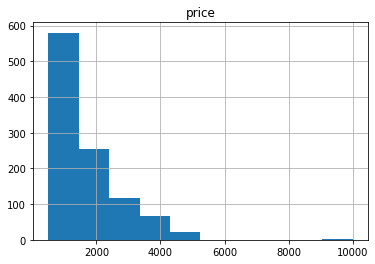

In [79]:
dfObjects[["price"]].hist()

Let's scale it and transfor using log function. 

In [82]:
dfObjects["lt"] = dfObjects["coords"].map(lambda x: x[0])
dfObjects["lg"] = dfObjects["coords"].map(lambda x: x[1])
scaler = preprocessing.MinMaxScaler()
dfObjects["priceLogScaled"] = scaler.fit_transform(np.log(dfObjects[["price"]]))
numColumns = ["priceLogScaled", "contamination", "distanceToDangerZone", 
                     "distanceToMedianJobLocation","GreenConc"]
dfObjects["totalScore"]=dfObjects.apply(lambda x: totalScore([x[i] for i in numColumns]), axis=1)
dfObjects

,id,type,address,price,coords,contamination,distanceToDangerZone,distanceToMedianJobLocation,Zone,GreenConc,lt,lg,priceLogScaled,totalScore
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]",0.142795,3.233713,1.131857,1.0,0.114630,45.478239,9.181948,0.231378,9.211560
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]",0.113508,1.818443,1.490735,1.0,0.114630,45.465710,9.171759,0.768622,-2.198958
2,link_ad_79920811,Bilocale,"corso Indipendenza 18, Indipendenza, Milano",1350,"[45.467451, 9.214442499999999]",0.269303,3.128875,1.924670,4.0,0.101857,45.467451,9.214442,0.331556,3.526012
3,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]",0.267291,3.113558,2.548148,3.0,0.121718,45.468144,9.222577,0.619647,-0.999047
4,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]",0.118938,3.057725,2.415785,3.0,0.121718,45.479340,9.217791,0.377671,1.335249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]",0.184149,3.771147,1.558796,3.0,0.121718,45.473714,9.209162,0.135348,10.072867
1035,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]",0.302823,1.720479,4.311302,8.0,0.149659,45.493978,9.146796,0.263194,-15.035905
1036,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]",0.723931,0.262662,5.856521,8.0,0.149659,45.508818,9.139578,0.177128,-31.726296
1037,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]",0.152961,3.252353,1.494612,9.0,0.174133,45.482363,9.183316,0.550336,6.142884


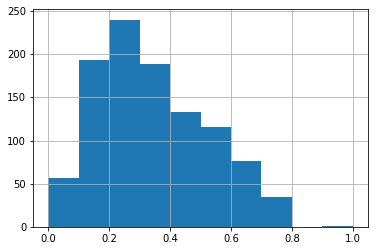

In [83]:
dfObjects["priceLogScaled"].hist()

### Saving DF

In [84]:
dfObjects.to_csv("dfObjects.csv", index = False)

### Creating a model for predicting price

#### Leaving only numerical columns

In [85]:
numColumns = ["price", "contamination", "distanceToDangerZone", 
                     "distanceToMedianJobLocation","GreenConc"]
dfFinal = dfObjects[["price", "contamination", "distanceToDangerZone", 
                     "distanceToMedianJobLocation","GreenConc"]]
dfFinal

,price,contamination,distanceToDangerZone,distanceToMedianJobLocation,GreenConc
0,1000,0.142795,3.233713,1.131857,0.114630
1,5000,0.113508,1.818443,1.490735,0.114630
2,1350,0.269303,3.128875,1.924670,0.101857
3,3200,0.267291,3.113558,2.548148,0.121718
4,1550,0.118938,3.057725,2.415785,0.121718
...,...,...,...,...,...
1034,750,0.184149,3.771147,1.558796,0.121718
1035,1100,0.302823,1.720479,4.311302,0.149659
1036,850,0.723931,0.262662,5.856521,0.149659
1037,2600,0.152961,3.252353,1.494612,0.174133


#### Scaling

In [86]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaled = scaler.fit_transform(dfFinal)
dfFinal = pd.DataFrame(scaled)
dfFinal.columns = numColumns

In [87]:
priceWeight = 5
dfFinal["totalScore"]=dfFinal.apply(lambda x: totalScore([x[i] for i in dfFinal.columns]), axis=1)
dfFinal

,price,contamination,distanceToDangerZone,distanceToMedianJobLocation,GreenConc,totalScore
0,0.052632,0.000875,0.012405,0.004186,0.485623,2.201676
1,0.473684,0.000859,0.006594,0.005628,0.485623,0.060234
2,0.089474,0.000945,0.011975,0.007371,0.375207,1.446961
3,0.284211,0.000944,0.011912,0.009875,0.546899,1.318907
4,0.110526,0.000862,0.011683,0.009343,0.546899,2.189251
...,...,...,...,...,...,...
1034,0.026316,0.000898,0.014612,0.005901,0.546899,2.641978
1035,0.063158,0.000964,0.006192,0.016956,0.788430,3.567723
1036,0.036842,0.001197,0.000207,0.023162,0.788430,3.637177
1037,0.221053,0.000881,0.012482,0.005643,1.000000,3.924525


In [88]:
dfObjectsScored = pd.concat([dfObjects[["id", "type", "address", "price","coords","lt","lg"]], dfFinal[["totalScore"]]], axis = 1)

In [89]:
dfObjectsScored

,id,type,address,price,coords,lt,lg,totalScore
0,link_ad_83897872,Monolocale,"piazzale Biancamano 2, Moscova, Milano",1000,"[45.47823899999999, 9.1819484]",45.478239,9.181948,2.201676
1,link_ad_83535941,Appartamento,"corso Magenta, San Vittore, Milano",5000,"[45.4657096, 9.1717594]",45.465710,9.171759,0.060234
2,link_ad_79920811,Bilocale,"corso Indipendenza 18, Indipendenza, Milano",1350,"[45.467451, 9.214442499999999]",45.467451,9.214442,1.446961
3,link_ad_83588673,Appartamento,"via Archimede, Plebisciti - Susa, Milano",3200,"[45.4681442, 9.2225773]",45.468144,9.222577,1.318907
4,link_ad_81088197,Trilocale,"via Sansovino 3, Città Studi, Milano",1550,"[45.4793396, 9.217790599999999]",45.479340,9.217791,2.189251
...,...,...,...,...,...,...,...,...
1034,link_ad_81522145,Monolocale,"via Melzo 13, Porta Venezia, Milano",750,"[45.4737135, 9.2091615]",45.473714,9.209162,2.641978
1035,link_ad_82925061,Quadrilocale,"via Fridtjof Nansen 8, Certosa, Milano",1100,"[45.493978, 9.1467958]",45.493978,9.146796,3.567723
1036,link_ad_80543223,Bilocale,"via Don Francesco Beniamino della Torre 2, Qua...",850,"[45.5088178, 9.1395781]",45.508818,9.139578,3.637177
1037,link_ad_83840748,Bilocale,"via Piero Maroncelli 5, Garibaldi - Corso Como...",2600,"[45.4823633, 9.1833156]",45.482363,9.183316,3.924525


### 9. Build model for predicting total score based on location

In [90]:
import numpy as np
import pandas as pd
import sklearn

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error



In [91]:
pd.get_dummies(dfObjectsScored["type"])

,Appartamento,Attico,Bilocale,Loft,"Loft,",Mansarda,Monolocale,Open,Quadrilocale,Terratetto,Trilocale,Villa
0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0,0,0,0,0,0,1,0,0,0,0,0
1035,0,0,0,0,0,0,0,0,1,0,0,0
1036,0,0,1,0,0,0,0,0,0,0,0,0
1037,0,0,1,0,0,0,0,0,0,0,0,0


In [92]:
dfPredict = pd.concat([pd.get_dummies(dfObjectsScored["type"]), dfObjectsScored[["lt", "lg", "totalScore", "price"]]], axis =1)
dfPredict

,Appartamento,Attico,Bilocale,Loft,"Loft,",Mansarda,Monolocale,Open,Quadrilocale,Terratetto,Trilocale,Villa,lt,lg,totalScore,price
0,0,0,0,0,0,0,1,0,0,0,0,0,45.478239,9.181948,2.201676,1000
1,1,0,0,0,0,0,0,0,0,0,0,0,45.465710,9.171759,0.060234,5000
2,0,0,1,0,0,0,0,0,0,0,0,0,45.467451,9.214442,1.446961,1350
3,1,0,0,0,0,0,0,0,0,0,0,0,45.468144,9.222577,1.318907,3200
4,0,0,0,0,0,0,0,0,0,0,1,0,45.479340,9.217791,2.189251,1550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0,0,0,0,0,0,1,0,0,0,0,0,45.473714,9.209162,2.641978,750
1035,0,0,0,0,0,0,0,0,1,0,0,0,45.493978,9.146796,3.567723,1100
1036,0,0,1,0,0,0,0,0,0,0,0,0,45.508818,9.139578,3.637177,850
1037,0,0,1,0,0,0,0,0,0,0,0,0,45.482363,9.183316,3.924525,2600


In [93]:
dfPredict.dropna(inplace = True)
dfPredict["Loft"] = dfPredict["Loft"] + dfPredict["Loft,"]
dfPredict["Loft"] = dfPredict["Loft"].map(lambda x: 1 if x>=1 else 0)
dfPredict.drop(columns = ["Loft,"], inplace = True)


In [94]:
dfPredict.dropna(inplace = True)
dfPredict

,Appartamento,Attico,Bilocale,Loft,Mansarda,Monolocale,Open,Quadrilocale,Terratetto,Trilocale,Villa,lt,lg,totalScore,price
0,0,0,0,0,0,1,0,0,0,0,0,45.478239,9.181948,2.201676,1000
1,1,0,0,0,0,0,0,0,0,0,0,45.465710,9.171759,0.060234,5000
2,0,0,1,0,0,0,0,0,0,0,0,45.467451,9.214442,1.446961,1350
3,1,0,0,0,0,0,0,0,0,0,0,45.468144,9.222577,1.318907,3200
4,0,0,0,0,0,0,0,0,0,1,0,45.479340,9.217791,2.189251,1550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0,0,0,0,0,1,0,0,0,0,0,45.473714,9.209162,2.641978,750
1035,0,0,0,0,0,0,0,1,0,0,0,45.493978,9.146796,3.567723,1100
1036,0,0,1,0,0,0,0,0,0,0,0,45.508818,9.139578,3.637177,850
1037,0,0,1,0,0,0,0,0,0,0,0,45.482363,9.183316,3.924525,2600


In [95]:
dfPredict.isnull().sum()

Appartamento    0
Attico          0
Bilocale        0
Loft            0
Mansarda        0
Monolocale      0
Open            0
Quadrilocale    0
Terratetto      0
Trilocale       0
Villa           0
lt              0
lg              0
totalScore      0
price           0
dtype: int64

In [96]:
def getOptimalNN(n_input, n_samples, n_classes = 1, classification = False, alpha = 5, n_layers = 1):
    """
    source: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    alpha [0,10]
    
    | Number of Hidden Layers | Result |

     0 - Only capable of representing linear separable functions or decisions.

     1 - Can approximate any function that contains a continuous mapping
    from one finite space to another.

     2 - Can represent an arbitrary decision boundary to arbitrary accuracy
    with rational activation functions and can approximate any smooth
    mapping to any accuracy.
    
    """
    
    res = [n_input]
    for i in range(n_layers):
        res.append(int(n_samples/(alpha*(n_input+n_classes))))
    if classification:
        print("Check n_classes if softmax is used. By default n_classes=1 which is suitable for regression")
    res.append(n_classes)
    return res

In [97]:
X_train, X_test, y_train, y_test = train_test_split(dfPredict[dfPredict.columns[:-1]], 
                                                    dfPredict[dfPredict.columns[-1:]], 
                                                    test_size=0.2)

In [98]:
getOptimalNN(len(X_train.columns), len(X_train))

[14, 11, 1]

In [99]:
def BuildModel():
    model = keras.Sequential()
    model.add(keras.layers.Dense(5000, input_dim=len(X_train.columns),activation='relu')) 
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")   
    return model

regressor = KerasRegressor(build_fn=BuildModel,nb_epoch=500,batch_size=3)
regressor.fit(X_train,y_train) 
y_pred = regressor.predict(X_test)

mean_squared_error(y_test, y_pred)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
276/276 [==============================] - 1s 2ms/step - loss: 1792744.2437
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not

882860.1910155055

In [100]:
y_test.reset_index(inplace = True, drop = True)


In [101]:
len(y_pred)

207

In [102]:
pd.concat([y_test, pd.DataFrame(y_pred)], axis = 1)

,price,0
0,1200,1442.212158
1,1600,1657.618774
2,700,1642.860229
3,900,1359.511475
4,1500,1763.502930
...,...,...
202,4000,1470.160278
203,1700,1783.396606
204,1000,1594.580688
205,700,1349.417358


In [103]:
mean_absolute_error(y_test, y_pred)

710.7559313198219

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score
rfr = RandomForestRegressor(max_samples=400)
rfr = TransformedTargetRegressor(regressor=RandomForestRegressor(),func=np.log1p,inverse_func=np.expm1)
rfr.fit(X_train,y_train)

(-1*cross_val_score(rfr, X_train, y_train, cv =5, scoring='neg_mean_squared_error')) ** 0.5
#y_pred = rfr.predict(X_test)

#mean_squared_error(y_test, y_pred)

array([543.73410296, 254.61763735, 370.32247515, 304.35497252,
       339.25470537])

In [105]:
y_pred = rfr.predict(X_test)

mean_squared_error(y_test, y_pred) ** 0.5

271.3908574758094

In [106]:
y_test.reset_index(inplace = True, drop = True)

In [107]:
pd.concat([y_test, pd.DataFrame(y_pred)], axis = 1)

,price,0
0,1200,1145.730121
1,1600,1744.959431
2,700,699.391440
3,900,898.697250
4,1500,1473.590888
...,...,...
202,4000,3882.796007
203,1700,1734.460003
204,1000,1050.921479
205,700,658.175487


In [108]:
mean_absolute_error(y_test, y_pred)

147.67179453191306

In [109]:
from collections import defaultdict

d = defaultdict()
for f, i in zip(X_test.columns,rfr.regressor_.feature_importances_):
    d[f] = i
d

defaultdict(None,
            {'Appartamento': 0.048465148955592265,
             'Attico': 0.0036334472773823117,
             'Bilocale': 0.07617423864218188,
             'Loft': 0.0020327846652833147,
             'Mansarda': 0.00014378776517002216,
             'Monolocale': 0.07188779514898448,
             'Open': 0.0006177375364384631,
             'Quadrilocale': 0.004638958861486179,
             'Terratetto': 4.327607196908578e-05,
             'Trilocale': 0.005737888490243642,
             'Villa': 0.000394479071870908,
             'lt': 0.28379354608591545,
             'lg': 0.11787515966998044,
             'totalScore': 0.38456175175750157})

In [110]:
{k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

{'Terratetto': 4.327607196908578e-05,
 'Mansarda': 0.00014378776517002216,
 'Villa': 0.000394479071870908,
 'Open': 0.0006177375364384631,
 'Loft': 0.0020327846652833147,
 'Attico': 0.0036334472773823117,
 'Quadrilocale': 0.004638958861486179,
 'Trilocale': 0.005737888490243642,
 'Appartamento': 0.048465148955592265,
 'Monolocale': 0.07188779514898448,
 'Bilocale': 0.07617423864218188,
 'lg': 0.11787515966998044,
 'lt': 0.28379354608591545,
 'totalScore': 0.38456175175750157}

In [111]:
mean_absolute_error(y_test, y_pred)

147.67179453191306

In [112]:
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures

# pf = PolynomialFeatures(degree=3)
X = X_train[["lt","lg"]]

y = X_train[["totalScore"]]
# rfr2 = LinearRegression()
# rfr2.fit(X,y)


from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score
rfr2 = RandomForestRegressor()
#rfr = TransformedTargetRegressor(regressor=RandomForestRegressor(),func=np.log1p,inverse_func=np.expm1)
rfr2.fit(X,y)



import pickle

pkl_filename = "rfr2.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rfr2, file)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


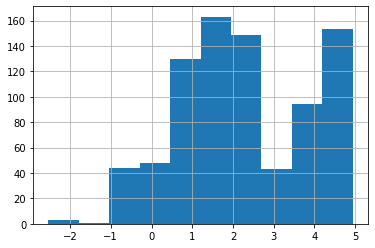

In [114]:
y["totalScore"].hist()